### Required Packages

In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

%matplotlib inline

In [58]:
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score , mean_squared_error , mean_absolute_error , mean_absolute_percentage_error
from sklearn.feature_selection import f_regression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices

### Datasets

In [59]:
car = pd.read_csv('C:/Users/Nithin/Downloads/Car Sales/Datasets/Car_sales - 1628437338663.csv')

### UDF

In [60]:
def continuous_var_summary( x ):
    
    # freq and missings
    n_total = x.shape[0]
    n_miss = x.isna().sum()
    perc_miss = n_miss * 100 / n_total
    
    # outliers - iqr
    q1 = x.quantile(0.25)
    q3 = x.quantile(0.75)
    iqr = q3 - q1
    lc_iqr = q1 - 1.5 * iqr
    uc_iqr = q3 + 1.5 * iqr
    
    
    return pd.Series( [ x.dtype, x.nunique(), n_total, x.count(), n_miss, perc_miss,
                       x.sum(), x.mean(), x.std(), x.var(), 
                       lc_iqr, uc_iqr, 
                       x.min(), x.quantile(0.01), x.quantile(0.05), x.quantile(0.10), 
                       x.quantile(0.25), x.quantile(0.5), x.quantile(0.75), 
                       x.quantile(0.90), x.quantile(0.95), x.quantile(0.99), x.max() ], 
                     
                    index = ['dtype', 'cardinality', 'n_tot', 'n', 'nmiss', 'perc_miss',
                             'sum', 'mean', 'std', 'var',
                        'lc_iqr', 'uc_iqr',
                        'min', 'p1', 'p5', 'p10', 'p25', 'p50', 'p75', 'p90', 'p95', 'p99', 'max']) 

In [61]:
# Create Data audit Report for categorical variables
def categorical_var_summary( x ):
    Mode = x.value_counts().sort_values(ascending = False)[0:1].reset_index()
    return pd.Series([x.count(), x.isnull().sum(), Mode.iloc[0, 0], Mode.iloc[0, 1], 
                          round(Mode.iloc[0, 1] * 100 / x.count(), 2)], 
                     
                  index = ['N', 'NMISS', 'MODE', 'FREQ', 'PERCENT'])

In [62]:
# Missing value imputation for continuous variables
def missing_imputation( x, stats = 'mean' ):
    if (x.dtypes == 'float64') | (x.dtypes == 'int64'):
        x = x.fillna(x.mean()) if stats == 'mean' else x.fillna(x.median())
    return x

In [63]:
# An utility function to create dummy variable
def create_dummies(df, colname):
    col_dummies = pd.get_dummies(df[colname], prefix = colname, drop_first = True)
    df = pd.concat([df, col_dummies], axis = 1)
    df.drop(colname, axis = 1, inplace = True )
    return df

### Data Inspection

In [64]:
car.columns

Index(['Manufacturer', 'Model', 'Sales_in_thousands', 'four_year_resale_value',
       'Vehicle_type', 'Price_in_thousands', 'Engine_size', 'Horsepower',
       'Wheelbase', 'Width', 'Length', 'Curb_weight', 'Fuel_capacity',
       'Fuel_efficiency', 'Latest_Launch', 'Power_perf_factor'],
      dtype='object')

In [65]:
car.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157 entries, 0 to 156
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Manufacturer            157 non-null    object 
 1   Model                   157 non-null    object 
 2   Sales_in_thousands      157 non-null    float64
 3   four_year_resale_value  121 non-null    float64
 4   Vehicle_type            157 non-null    object 
 5   Price_in_thousands      155 non-null    float64
 6   Engine_size             156 non-null    float64
 7   Horsepower              156 non-null    float64
 8   Wheelbase               156 non-null    float64
 9   Width                   156 non-null    float64
 10  Length                  156 non-null    float64
 11  Curb_weight             155 non-null    float64
 12  Fuel_capacity           156 non-null    float64
 13  Fuel_efficiency         154 non-null    float64
 14  Latest_Launch           157 non-null    ob

In [66]:
car.nunique()

# If variable with all unique value & categorical can be rejcted

Manufacturer               30
Model                     156
Sales_in_thousands        157
four_year_resale_value    117
Vehicle_type                2
Price_in_thousands        152
Engine_size                31
Horsepower                 66
Wheelbase                  88
Width                      78
Length                    127
Curb_weight               147
Fuel_capacity              55
Fuel_efficiency            20
Latest_Launch             130
Power_perf_factor         154
dtype: int64

In [67]:
car.dtypes

Manufacturer               object
Model                      object
Sales_in_thousands        float64
four_year_resale_value    float64
Vehicle_type               object
Price_in_thousands        float64
Engine_size               float64
Horsepower                float64
Wheelbase                 float64
Width                     float64
Length                    float64
Curb_weight               float64
Fuel_capacity             float64
Fuel_efficiency           float64
Latest_Launch              object
Power_perf_factor         float64
dtype: object

In [68]:
# Split based on dtypes

cont = car.select_dtypes(['int64','float64']).columns
cat = car.select_dtypes(['object']).columns

In [69]:
car_cont = car[cont]
car_cat = car[cat]

In [70]:
car_cont.apply(continuous_var_summary)

,Sales_in_thousands,four_year_resale_value,Price_in_thousands,Engine_size,Horsepower,Wheelbase,Width,Length,Curb_weight,Fuel_capacity,Fuel_efficiency,Power_perf_factor
dtype,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
cardinality,157,117,152,31,66,88,78,127,147,55,20,154
n_tot,157,157,157,157,157,157,157,157,157,157,157,157
n,157,121,155,156,156,156,156,156,155,156,154,155
nmiss,0,36,2,1,1,1,1,1,2,1,3,2
perc_miss,0.0,22.929936,1.273885,0.636943,0.636943,0.636943,0.636943,0.636943,1.273885,0.636943,1.910828,1.273885
sum,8320.698,2186.83,4245.567,477.5,29008.0,16768.0,11099.4,29225.6,523.594,2800.5,3672.0,11941.756636
mean,52.998076,18.072975,27.390755,3.060897,185.948718,107.487179,71.15,187.34359,3.378026,17.951923,23.844156,77.043591
std,68.029422,11.453384,14.351653,1.044653,56.700321,7.641303,3.451872,13.431754,0.630502,3.887921,4.282706,25.142664
var,4628.002257,131.180007,205.969949,1.0913,3214.926385,58.389512,11.915419,180.412023,0.397532,15.115932,18.341567,632.153558


In [71]:
car_cat.apply(categorical_var_summary)

,Manufacturer,Model,Vehicle_type,Latest_Launch
N,157,157,157,157
NMISS,0,0,0,0
MODE,Dodge,Neon,Passenger,10/5/2012
FREQ,11,2,116,2
PERCENT,7.01,1.27,73.89,1.27


### Outlier Treatment

In [72]:
car_cont = car_cont.apply(lambda x : x.clip(lower = x.quantile(0.01),
                                  upper = x.quantile(0.99)))

In [73]:
car_cont.apply(continuous_var_summary)

,Sales_in_thousands,four_year_resale_value,Price_in_thousands,Engine_size,Horsepower,Wheelbase,Width,Length,Curb_weight,Fuel_capacity,Fuel_efficiency,Power_perf_factor
dtype,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
cardinality,155,115,150,29,64,87,76,125,145,54,19,152
n_tot,157,157,157,157,157,157,157,157,157,157,157,157
n,157,121,155,156,156,156,156,156,155,156,154,155
nmiss,0,36,2,1,1,1,1,1,2,1,3,2
perc_miss,0.0,22.929936,1.273885,0.636943,0.636943,0.636943,0.636943,0.636943,1.273885,0.636943,1.910828,1.273885
sum,8025.5292,2180.421,4235.95548,475.81,28910.3,16760.1,11102.45,29223.94,523.77016,2799.9,3660.0,11911.685368
mean,51.11802,18.020008,27.328745,3.050064,185.322436,107.436538,71.169551,187.332949,3.379162,17.948077,23.766234,76.849583
std,57.722699,11.181335,14.06397,0.982279,52.81647,7.424295,3.390339,13.12035,0.621764,3.819854,3.994755,23.844968
var,3331.909938,125.02226,197.795238,0.964871,2789.579526,55.120156,11.4944,172.143594,0.386591,14.591287,15.958068,568.58248


### Missing Value Treatment

In [74]:
car_cont = car_cont.apply(missing_imputation)

In [75]:
car_cont.apply(continuous_var_summary)

,Sales_in_thousands,four_year_resale_value,Price_in_thousands,Engine_size,Horsepower,Wheelbase,Width,Length,Curb_weight,Fuel_capacity,Fuel_efficiency,Power_perf_factor
dtype,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
cardinality,155,116,151,30,65,88,77,126,146,55,20,153
n_tot,157,157,157,157,157,157,157,157,157,157,157,157
n,157,157,157,157,157,157,157,157,157,157,157,157
nmiss,0,0,0,0,0,0,0,0,0,0,0,0
perc_miss,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sum,8025.5292,2829.141298,4290.61297,478.860064,29095.622436,16867.536538,11173.619551,29411.272949,530.528485,2817.848077,3731.298701,12065.384534
mean,51.11802,18.020008,27.328745,3.050064,185.322436,107.436538,71.169551,187.332949,3.379162,17.948077,23.766234,76.849583
std,57.722699,9.80668,13.973525,0.979125,52.646914,7.400461,3.379455,13.07823,0.617766,3.807591,3.956157,23.691622
var,3331.909938,96.170969,195.259402,0.958686,2771.697606,54.766822,11.420718,171.04011,0.381634,14.497753,15.651182,561.292961


### Dummy Variable Creation

In [76]:
car_cat = car_cat.loc[:,['Manufacturer','Vehicle_type']]

In [77]:
for car_feat in car_cat:
    car_cat.loc[:,car_feat] = car_cat[car_feat].astype('category')
    car_cat = create_dummies(car_cat,car_feat)

In [78]:
car_cat.columns

Index(['Manufacturer_Audi', 'Manufacturer_BMW', 'Manufacturer_Buick',
       'Manufacturer_Cadillac', 'Manufacturer_Chevrolet',
       'Manufacturer_Chrysler', 'Manufacturer_Dodge', 'Manufacturer_Ford',
       'Manufacturer_Honda', 'Manufacturer_Hyundai', 'Manufacturer_Infiniti',
       'Manufacturer_Jaguar', 'Manufacturer_Jeep', 'Manufacturer_Lexus',
       'Manufacturer_Lincoln', 'Manufacturer_Mercedes-B',
       'Manufacturer_Mercury', 'Manufacturer_Mitsubishi',
       'Manufacturer_Nissan', 'Manufacturer_Oldsmobile',
       'Manufacturer_Plymouth', 'Manufacturer_Pontiac', 'Manufacturer_Porsche',
       'Manufacturer_Saab', 'Manufacturer_Saturn', 'Manufacturer_Subaru',
       'Manufacturer_Toyota', 'Manufacturer_Volkswagen', 'Manufacturer_Volvo',
       'Vehicle_type_Passenger'],
      dtype='object')

In [79]:
#Colnames as per INC rules
car_cat.rename(columns= {'Manufacturer_Mercedes-B':'Manufacturer_Mercedes_B'},inplace=True)

### Final Dataset

In [80]:
car_final = pd.concat([car_cont,car_cat],axis = 1)

### Assumption check

C:\Users\Nithin\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Sales_in_thousands', ylabel='Density'>

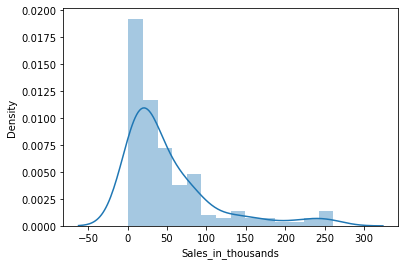

In [81]:
#Checking if y variabvle is normally distrubued

sns.distplot(car_final.Sales_in_thousands)

In [82]:
car_final.Sales_in_thousands.skew().round(2)

1.99

In [83]:
#To Normalise y we are creating a new log column

car_final['ln_sales'] = np.log(car_final.Sales_in_thousands)

C:\Users\Nithin\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='ln_sales', ylabel='Density'>

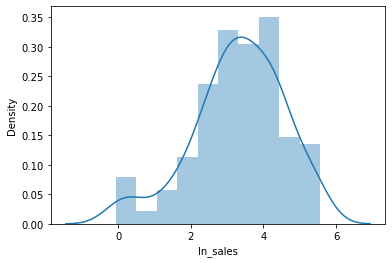

In [84]:
sns.distplot(car_final.ln_sales)

In [85]:
car_final.ln_sales.skew().round(2)

-0.59

### Corelation Matrix

In [86]:
car_final.corr().to_csv('C:/Users/Nithin/Downloads/Car Sales/corel.csv')

<AxesSubplot:>

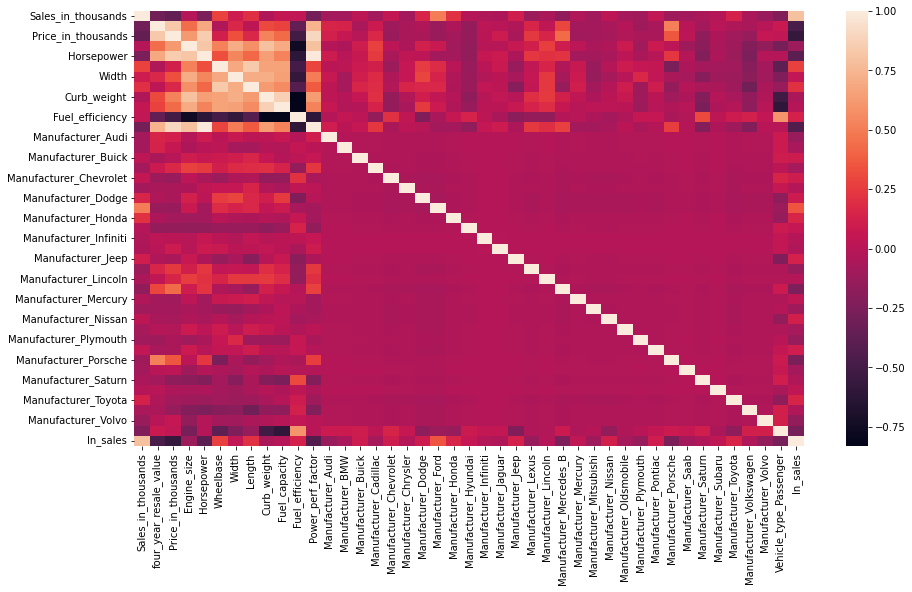

In [87]:
plt.figure(figsize= (15,8))
sns.heatmap(car_final.corr())

### Feature Reduction

In [88]:
#f_regression -> Significant Features
feat_cols = car_final.columns.difference(['Sales_in_thousands','ln_sales'])

In [89]:
predictors = car_final[feat_cols]
target = car_final.ln_sales

In [90]:
f_values,p_values = f_regression(predictors,target)

In [91]:
f_reg_out = pd.concat( [ pd.Series(feat_cols), 
                    pd.Series(f_values).round(2), 
                        pd.Series(p_values).round(4) ], axis = 1 )

In [92]:
f_reg_out.columns = ['Features','f_values','p_values']

In [93]:
feat_sig = f_reg_out.loc[f_reg_out.p_values < 0.1,'Features']

In [94]:
#VIF(Variance Inflation Factor) -> to reduce multi colinearity among significant features
#Vif <= 4
model_param = 'ln_sales ~ '+' + '.join(feat_sig)

In [95]:
model_param

'ln_sales ~ Fuel_efficiency + Horsepower + Length + Manufacturer_Audi + Manufacturer_Ford + Manufacturer_Honda + Manufacturer_Mercedes_B + Manufacturer_Plymouth + Manufacturer_Porsche + Manufacturer_Toyota + Manufacturer_Volvo + Power_perf_factor + Price_in_thousands + Vehicle_type_Passenger + Wheelbase + four_year_resale_value'

In [96]:
model_param = '''ln_sales ~ Fuel_efficiency + Length + 
               Manufacturer_Audi + Manufacturer_Ford + Manufacturer_Honda +
               Manufacturer_Mercedes_B + Manufacturer_Plymouth + Manufacturer_Porsche + 
               Manufacturer_Toyota + Manufacturer_Volvo + 
               Price_in_thousands + Vehicle_type_Passenger'''

In [97]:
y,x = dmatrices(model_param,car_final,return_type='dataframe')

In [98]:
vif = pd.DataFrame()

vif['Features'] = x.columns
vif['vif_factor'] = [variance_inflation_factor(x.values,i) for i in range(x.shape[1])]
vif.round(2)

,Features,vif_factor
0,Intercept,568.59
1,Fuel_efficiency,4.02
2,Length,1.44
3,Manufacturer_Audi,1.06
4,Manufacturer_Ford,1.08
5,Manufacturer_Honda,1.09
6,Manufacturer_Mercedes_B,1.60
7,Manufacturer_Plymouth,1.03
8,Manufacturer_Porsche,1.38
9,Manufacturer_Toyota,1.15


In [99]:
feat_final = list(set(vif.loc[:,'Features']).difference(['Intercept']))

In [100]:
feat_final

['Manufacturer_Porsche',
 'Manufacturer_Plymouth',
 'Manufacturer_Ford',
 'Manufacturer_Volvo',
 'Fuel_efficiency',
 'Manufacturer_Mercedes_B',
 'Length',
 'Manufacturer_Honda',
 'Vehicle_type_Passenger',
 'Manufacturer_Toyota',
 'Price_in_thousands',
 'Manufacturer_Audi']

### Train & Test Model

In [101]:
train,test = train_test_split(car_final,test_size=0.3,random_state=12345)

### Building LR Model

In [102]:
predictors = car_final.columns.difference(['Sales_in_thousands','ln_sales'])

##### Model 0

In [103]:
m0 = 'ln_sales ~ ' + ' + '.join(predictors)

In [104]:
lm0 = smf.ols(m0,car_final).fit()

In [105]:
print(lm0.summary())

                            OLS Regression Results                            
Dep. Variable:               ln_sales   R-squared:                       0.707
Model:                            OLS   Adj. R-squared:                  0.603
Method:                 Least Squares   F-statistic:                     6.777
Date:                Tue, 27 Sep 2022   Prob (F-statistic):           2.47e-16
Time:                        18:53:15   Log-Likelihood:                -162.17
No. Observations:                 157   AIC:                             408.3
Df Residuals:                     115   BIC:                             536.7
Df Model:                          41                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

##### Model 1

In [106]:
m1 = 'ln_sales ~ ' + ' + '.join(feat_final)

In [107]:
lm1 = smf.ols(m1,train).fit()

In [108]:
print(lm1.summary())

                            OLS Regression Results                            
Dep. Variable:               ln_sales   R-squared:                       0.584
Model:                            OLS   Adj. R-squared:                  0.532
Method:                 Least Squares   F-statistic:                     11.21
Date:                Tue, 27 Sep 2022   Prob (F-statistic):           1.15e-13
Time:                        18:53:15   Log-Likelihood:                -132.77
No. Observations:                 109   AIC:                             291.5
Df Residuals:                      96   BIC:                             326.5
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

##### Model  2

In [109]:
m2 = '''ln_sales ~ Fuel_efficiency +
            Vehicle_type_Passenger +
            Price_in_thousands + Length +
            Manufacturer_Ford'''

In [110]:
lm2 = smf.ols(m2,train).fit()

In [111]:
print(lm2.summary())

                            OLS Regression Results                            
Dep. Variable:               ln_sales   R-squared:                       0.526
Model:                            OLS   Adj. R-squared:                  0.503
Method:                 Least Squares   F-statistic:                     22.83
Date:                Tue, 27 Sep 2022   Prob (F-statistic):           2.33e-15
Time:                        18:53:15   Log-Likelihood:                -139.86
No. Observations:                 109   AIC:                             291.7
Df Residuals:                     103   BIC:                             307.9
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -4

### Predict the Output

In [112]:
train.loc[:,'Pred_sales'] = np.exp(lm2.predict(train))

C:\Users\Nithin\anaconda3\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [113]:
test['pred_sales'] = np.exp(lm2.predict(test))

C:\Users\Nithin\AppData\Local\Temp/ipykernel_18836/16629166.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['pred_sales'] = np.exp(lm2.predict(test))


In [114]:
train[['Sales_in_thousands','Pred_sales']].mean()

Sales_in_thousands    51.427006
Pred_sales            39.738783
dtype: float64

### Scoring Model

##### MSE

In [115]:
MSE_train = mean_squared_error(train.Sales_in_thousands,train.Pred_sales).round(2)
MSE_test = mean_squared_error(test.Sales_in_thousands,test.pred_sales).round(2)

RMSE_train = np.sqrt(MSE_train).round(2)
RMSE_test = np.sqrt(MSE_test).round(2)

print('MSE of training data: ', MSE_train,  ' | ', 'MSE of testing data: ', MSE_test)
print('RMSE of training data: ', RMSE_train,  ' | ', 'RMSE of testing data: ', RMSE_test)

MSE of training data:  2455.25  |  MSE of testing data:  4302.98
RMSE of training data:  49.55  |  RMSE of testing data:  65.6


##### MAE

In [116]:
MAE_train = mean_absolute_error(train.Sales_in_thousands,train.Pred_sales).round(2)
MAE_test = mean_absolute_error(test.Sales_in_thousands,test.pred_sales).round(2)

print('MAE of training data: ', MAE_train,  ' | ', 'MAE of testing data: ', MAE_test)

MAE of training data:  28.89  |  MAE of testing data:  35.96


##### MAPE

In [117]:
MAPE_train = mean_absolute_percentage_error(train.Sales_in_thousands,train.Pred_sales).round(2)
MAPE_test = mean_absolute_percentage_error(test.Sales_in_thousands,test.pred_sales).round(2)

print('MAPE of training data: ', MAPE_train,  ' | ', 'MAPE of testing data: ', MAPE_test)

MAPE of training data:  1.13  |  MAPE of testing data:  0.77


##### Co-relation

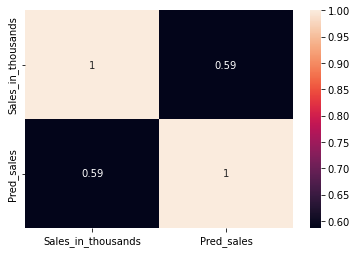

<AxesSubplot:>

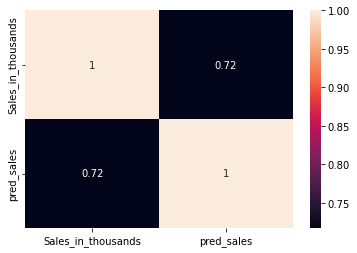

In [124]:
sns.heatmap(train[['Sales_in_thousands','Pred_sales']].corr(),annot=True)
plt.show()
sns.heatmap(test[['Sales_in_thousands','pred_sales']].corr(),annot=True)

C:\Users\Nithin\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


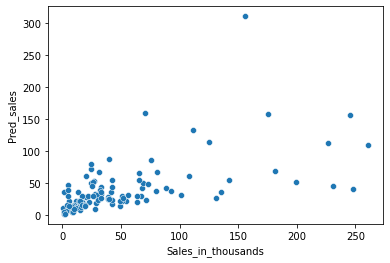

C:\Users\Nithin\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Sales_in_thousands', ylabel='pred_sales'>

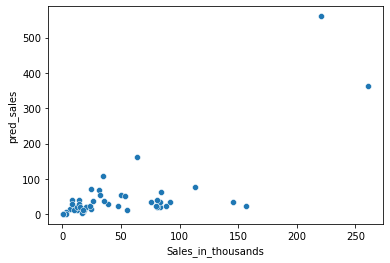

In [126]:
sns.scatterplot(train.Sales_in_thousands,train.Pred_sales)
plt.show()
sns.scatterplot(test.Sales_in_thousands,test.pred_sales)

### Model Validation

##### Decile Analysis

In [132]:
train.loc[:,'Decile'] = pd.qcut(train.Pred_sales,10,labels=False)
test.loc[:,'Decile'] = pd.qcut(test.pred_sales,10,labels=False)

C:\Users\Nithin\anaconda3\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
C:\Users\Nithin\anaconda3\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [148]:
DA_train = train.groupby('Decile')[['Sales_in_thousands','Pred_sales']].mean().round(2).sort_index( ascending = False)
DA_test = test.groupby('Decile')[['Sales_in_thousands','pred_sales']].mean().round(2).sort_index( ascending = False)

In [160]:
DA_train.to_csv('C:/Users/Nithin/Downloads/Car Sales/Datasets/DA_train.csv')
DA_test.to_csv('C:/Users/Nithin/Downloads/Car Sales/Datasets/DA_test.csv')

C:\Users\Nithin\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

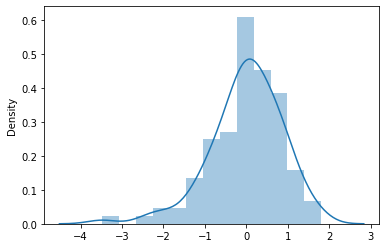

In [154]:
#Error - Normal
sns.distplot(lm2.resid)

In [156]:
#Error Mean to be zero
lm2.resid.mean()

2.0526903316762184e-14

In [157]:
#Error not to be corel to y var
stats.stats.pearsonr(lm2.resid,train.ln_sales)

(0.6886799858071841, 1.2713487518659242e-16)

C:\Users\Nithin\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='ln_sales'>

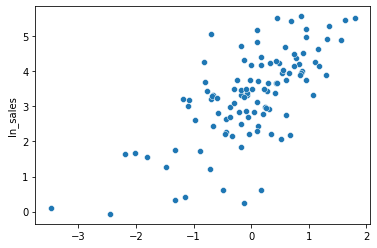

In [158]:
#Error Homosedasticity
sns.scatterplot(lm2.resid,train.ln_sales)

### Conclusion

##### 1. Small Sample so not able to predict
##### 2. Assumption in the model are not true